In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict,Literal
from langchain_google_genai import GoogleGenerativeAI
from pydantic import BaseModel, Field
from dotenv import load_dotenv
load_dotenv()
model = GoogleGenerativeAI(model="gemini-1.5-pro")

In [2]:
class SantimentSchema(TypedDict):
    sentiment: Literal['positive', 'negative'] = Field(
        description="The sentiment of review")

In [16]:
input1 = "- tell this review is positive or negative santiment. Write only single word 'positive' or 'negative'. Do not write any other words."

In [17]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal['positive', 'negative']
    diagnosis: dict
    response: str

In [18]:
def find_santiment(review: ReviewState) -> ReviewState:
    response = model.invoke(
        review['review']+input1
    )
    review['sentiment'] = response
    return review

def check_santiment(review: ReviewState) -> Literal['positive_response', 'run_diagnosis']:
    if review['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    
def positive_response(review: ReviewState) -> ReviewState:
    review['response'] = "This is a positive review"
    return review   

def run_diagnosis(review: ReviewState) -> ReviewState: 
    review['diagnosis'] = model.invoke(
        "Run a diagnosis for this review: "+review['review'])
    review['response'] = "This is a negative review. Diagnosis: "+str(review['diagnosis'])
    return review

In [19]:
graph = StateGraph(ReviewState)

graph.add_node("find_santiment",find_santiment)
graph.add_node("positive_response",positive_response)
graph.add_node("run_diagnosis",run_diagnosis)


graph.add_edge(START, "find_santiment")
graph.add_conditional_edges("find_santiment", check_santiment)
graph.add_edge("positive_response", END)
graph.add_edge("run_diagnosis", END)

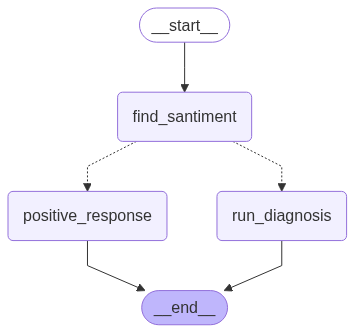

In [20]:
workflow = graph.compile()
workflow

In [22]:
answer = workflow.invoke({'review': "There are several issue in this product"})
answer

{'review': 'There are several issue in this product',
 'sentiment': 'negative',
 'diagnosis': 'The review "There are several issues in this product" is **too vague and unhelpful**.  Here\'s a diagnosis of its problems:\n\n* **Lack of Specificity:** The biggest issue is the lack of detail.  "Several issues" doesn\'t tell the reader *anything* about what\'s wrong with the product.  Are the issues related to functionality, durability, design, or something else entirely?\n* **Low Information Value:**  Because it\'s so vague, the review provides almost no useful information to potential buyers or the product manufacturer.  It doesn\'t help anyone make an informed decision.\n* **Reduced Credibility:** The lack of specifics can make the reviewer seem less credible.  Readers might assume the reviewer is exaggerating, didn\'t actually use the product, or is just trying to leave a negative review without justification.\n* **Unactionable Feedback for the Manufacturer:**  If a company receives thi